In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


**1: EDA**

P. S. Большая часть кода данной секции отсутсвует, чтобы сделать всё более компактным и более "читабельным"

In [2]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
test_ids = test['Id']

In [5]:
#просмотрим пропуски
for col in train.columns:
    if train[col].isna().sum() != 0:
        print(col + ':' + str(train[col].isna().sum()))

LotFrontage:259
Alley:1369
MasVnrType:8
MasVnrArea:8
BsmtQual:37
BsmtCond:37
BsmtExposure:38
BsmtFinType1:37
BsmtFinType2:38
Electrical:1
FireplaceQu:690
GarageType:81
GarageYrBlt:81
GarageFinish:81
GarageQual:81
GarageCond:81
PoolQC:1453
Fence:1179
MiscFeature:1406


In [6]:
train.head(7)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000


In [7]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [8]:
# в основном на данном этапе каждую из фич я изучал следующими двумя способами, 
#иногда прибегая к другим средствам, вроде таблиц кореляций, графиков и т.д.
train['BsmtQual'].value_counts()

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

In [9]:
train[['BsmtQual', 'SalePrice']].groupby(by = 'BsmtQual').describe()

SalePrice                                                    \
             count           mean            std       min       25%   
BsmtQual                                                               
Ex           121.0  327041.041322  113563.237392  123500.0  255500.0   
Fa            35.0  115692.028571   34469.667278   61000.0   91400.0   
Gd           618.0  202688.478964   58092.364284   75500.0  165100.0   
TA           649.0  140759.818182   43483.265311   34900.0  117000.0   

                                        
               50%       75%       max  
BsmtQual                                
Ex        318000.0  378500.0  755000.0  
Fa        112000.0  133500.0  206900.0  
Gd        192070.0  234000.0  538000.0  
TA        135500.0  158000.0  475000.0

In [10]:
cols_to_drop = ['Id', 'MiscFeature', 'PoolArea', 'Fireplaces', 'Alley', 'GarageYrBlt',
                'WoodDeckSF', 'GarageCars', 'OpenPorchSF', 'EnclosedPorch',
                '3SsnPorch', 'ScreenPorch', 'GarageQual', 'Street',
                'LotShape', 'Utilities', 'LotConfig', 'LandSlope', 'Condition2', 'OverallCond',
                'YearBuilt', 'YearRemodAdd', 'RoofMatl', 'ExterQual', 'MasVnrArea',
                'BsmtFinSF2', 'BsmtFinType2', 'BsmtFinType1', 'BsmtQual', 'BsmtUnfSF', 
                'Heating', 'BsmtHalfBath'] 
# 32 (из 79) фич я решил убрать по причине того что некоторые повторяли друг друга (например OverallQual and OverallCond),
# другие недостаточно представлены (Utilities из 4 возможных лэйблов указанных в описании данных на странице соревнования, 
# только 2 представлены в train данных) или просто малоинформативны.
train.drop(cols_to_drop, axis = 1, inplace = True)
test.drop(cols_to_drop, axis = 1, inplace = True)

In [11]:
#для некотых фич допустим лэбл "NA" вместо NaN значений, согласно описанию данных
cat_feature_with_none_label = ['PoolQC', 'Fence', 'GarageCond', 'GarageType', 'FireplaceQu',
                               'BsmtExposure', 'BsmtCond','MasVnrType', 'GarageFinish']

for i in cat_feature_with_none_label:
    train[i].fillna('NA', inplace = True)
    test[i].fillna('NA', inplace = True)

#заполняем пропущенные значения в других случаях
train['Electrical'].fillna(test['Electrical'].mode()[0], inplace=True)
l_frontage_v = round(train['LotFrontage'].mean(), 1)
train['LotFrontage'].fillna(l_frontage_v, inplace = True)
test['LotFrontage'].fillna(l_frontage_v, inplace = True)

In [12]:
for i in test.columns:
    if test[i].dtype == float:
        cur_median = round(test[i].mean(), 1)
        test[i].fillna(cur_median, inplace = True)
    if test[i].dtype == object:
        test[i].fillna(test[i].mode()[0], inplace=True)


MSSubClass


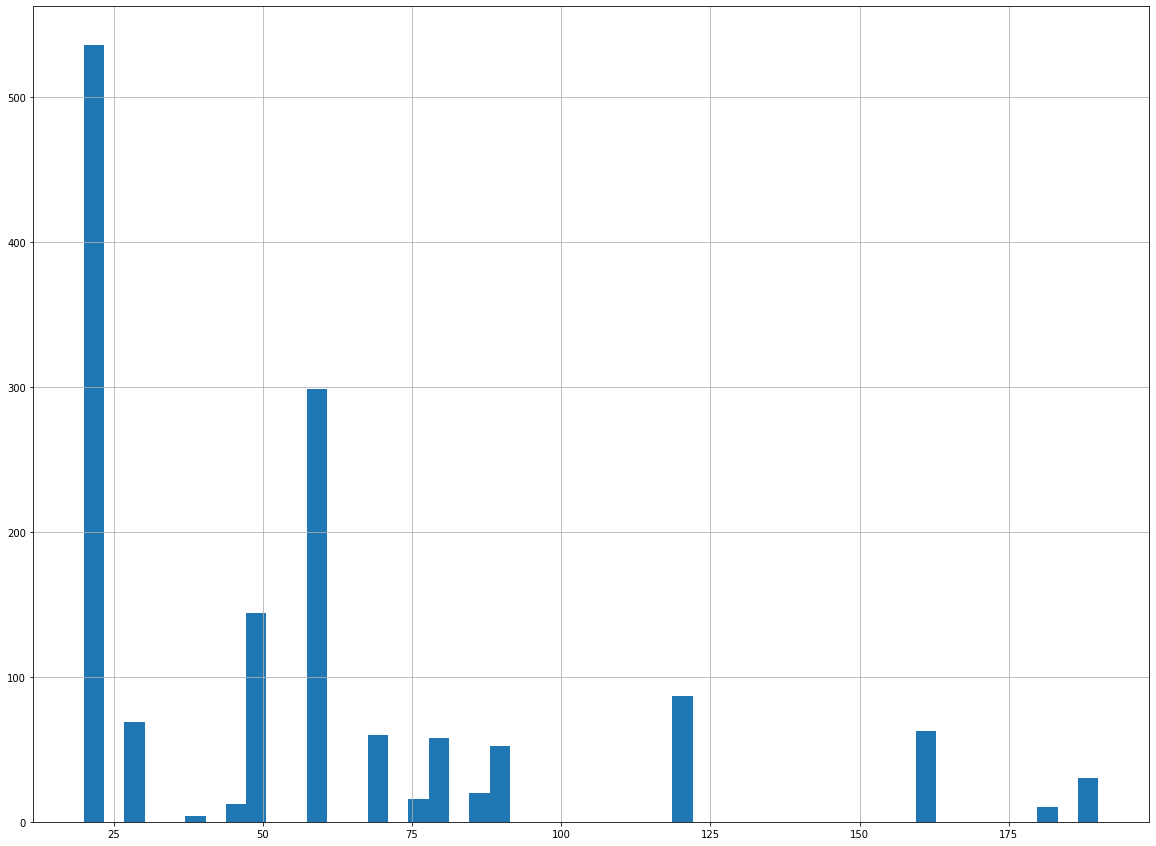

LotFrontage


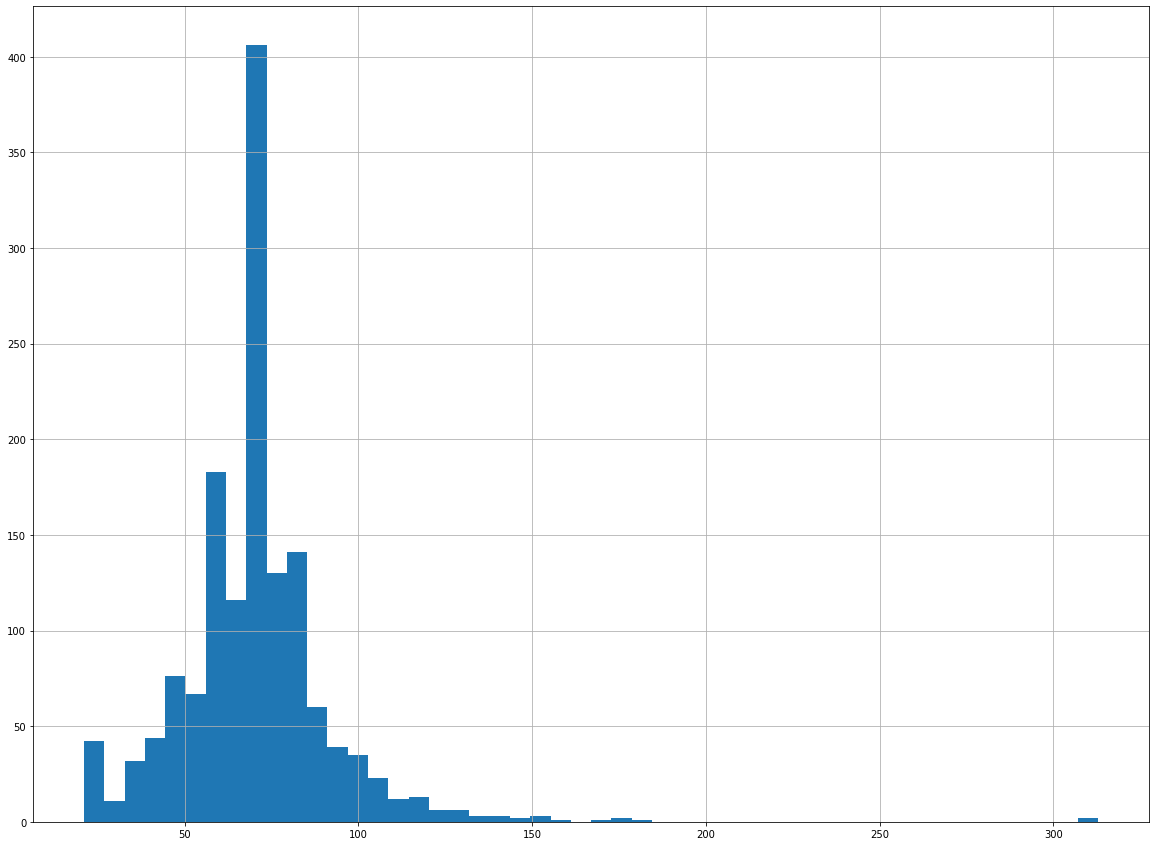

LotArea


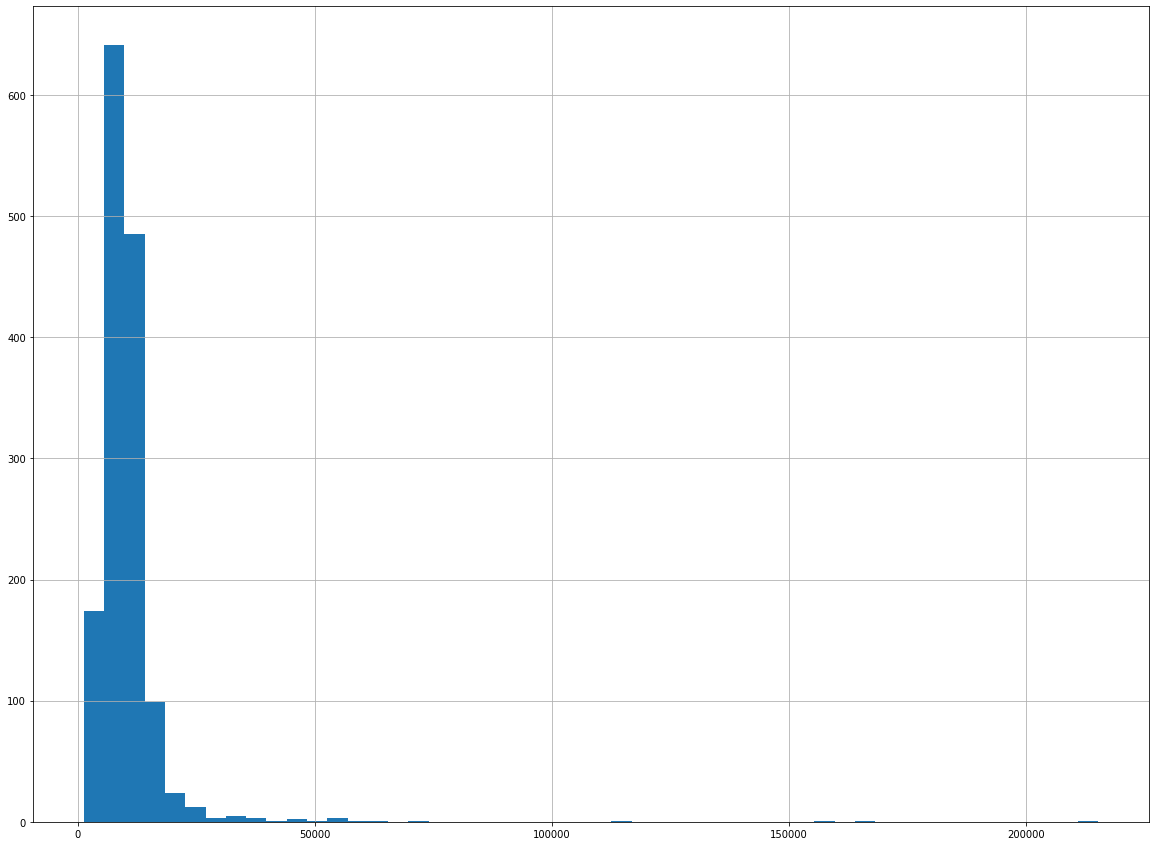

OverallQual


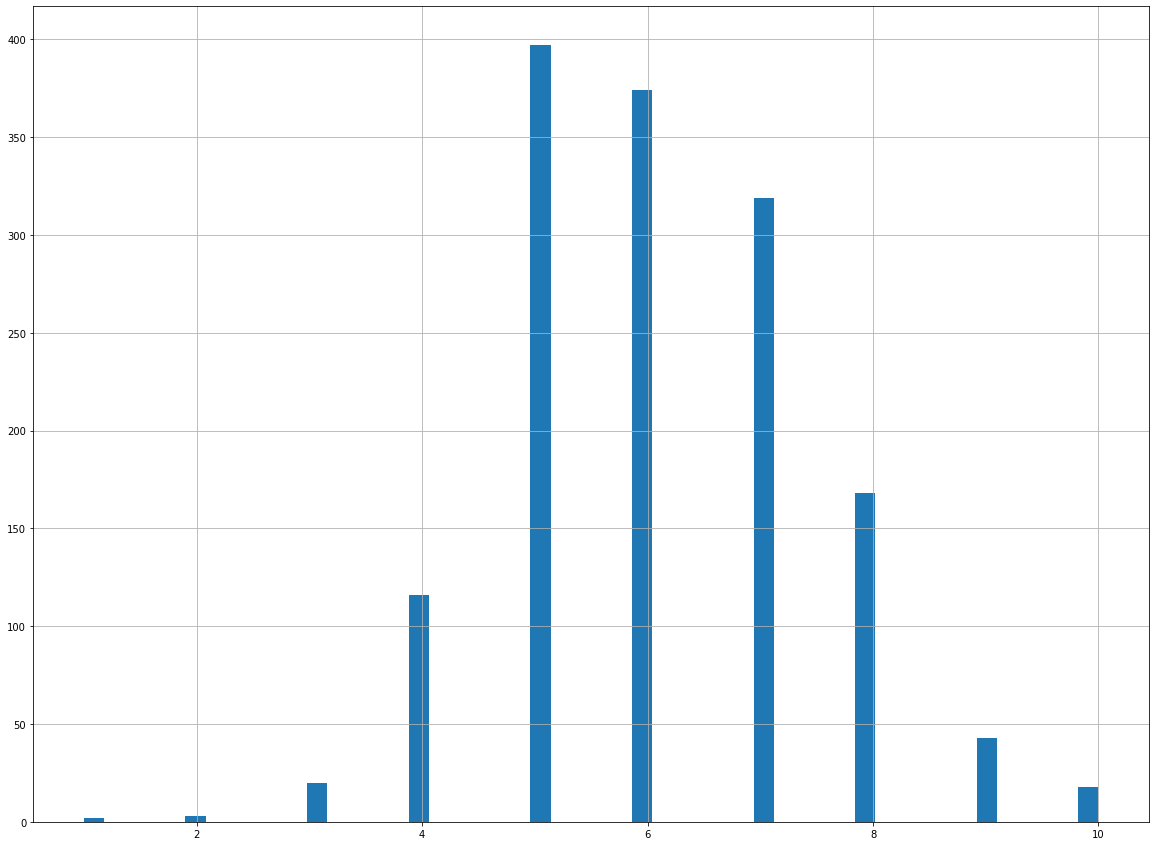

BsmtFinSF1


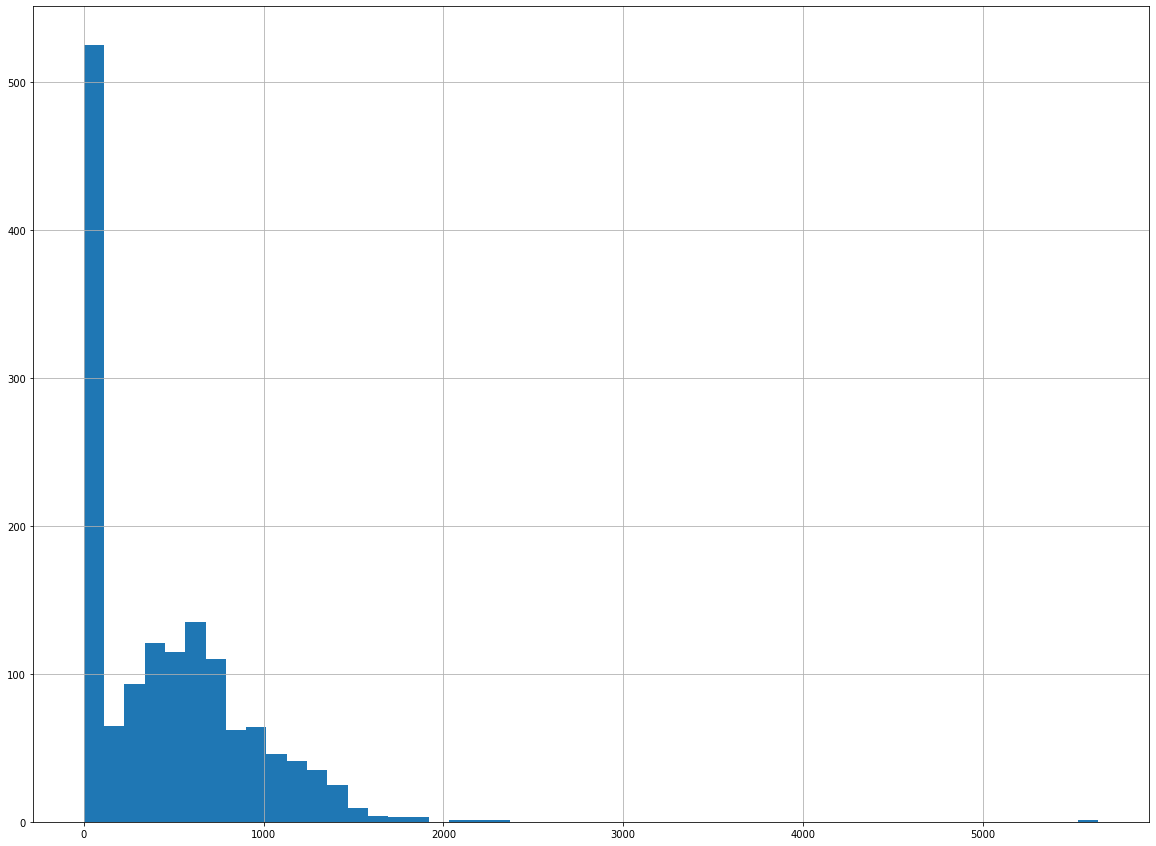

TotalBsmtSF


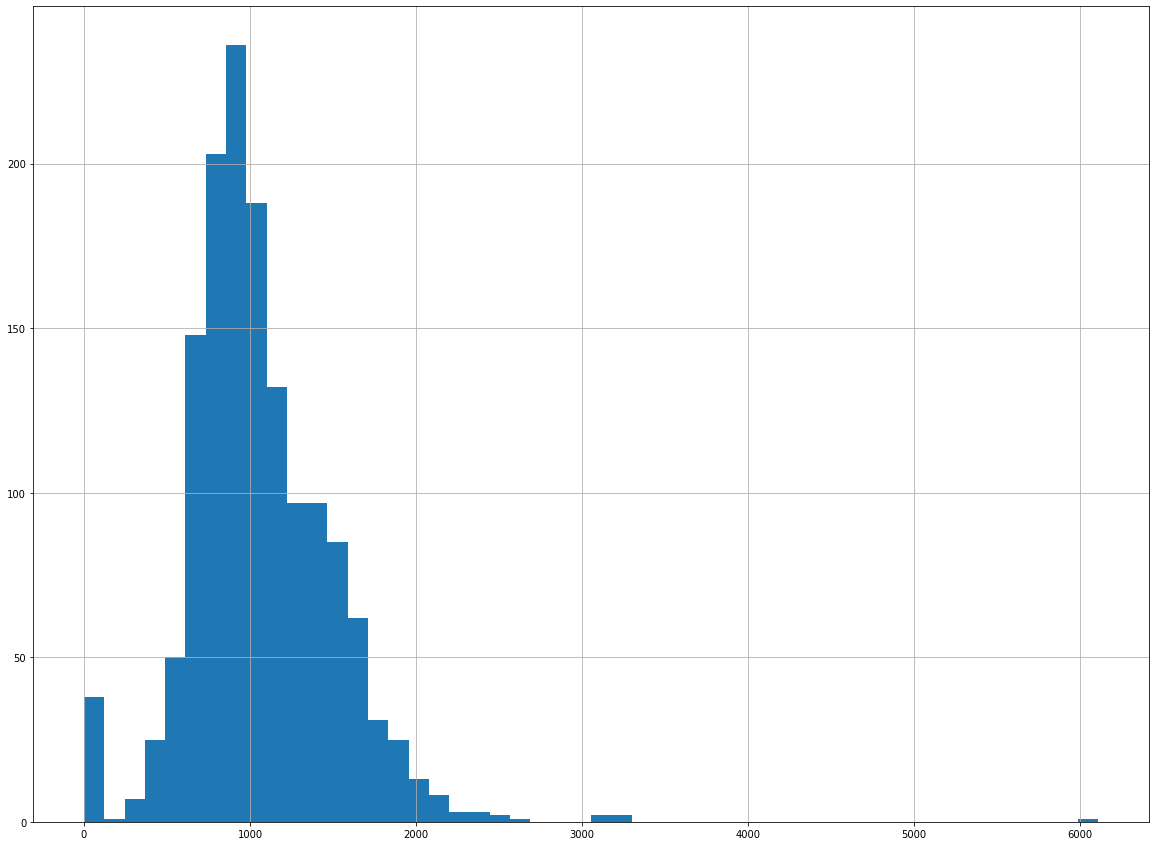

1stFlrSF


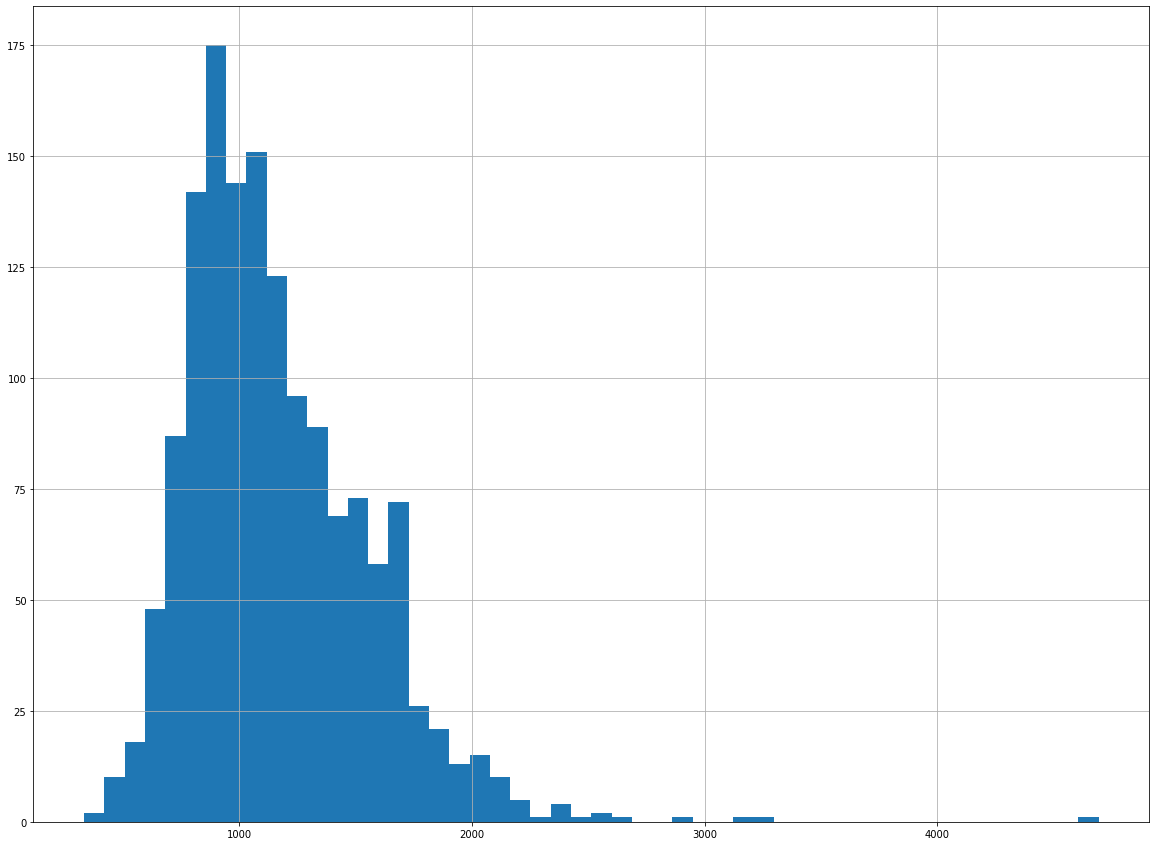

2ndFlrSF


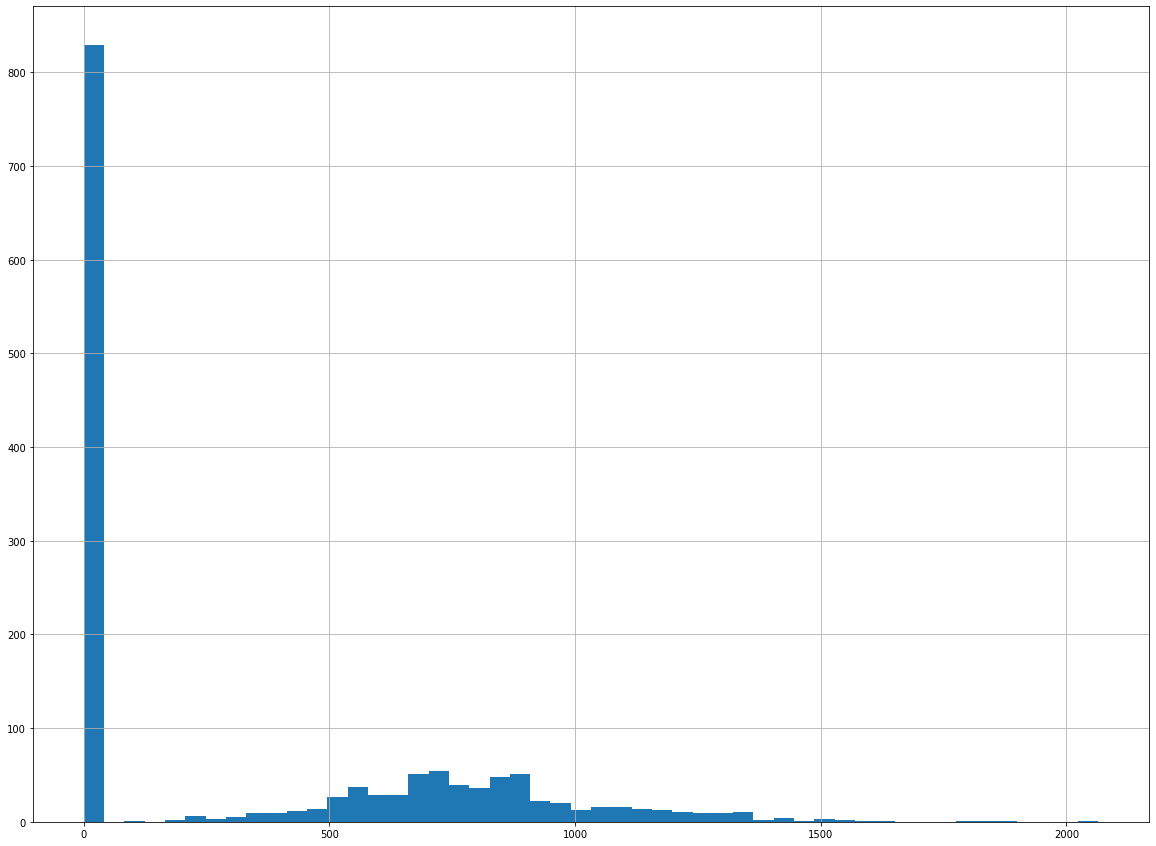

LowQualFinSF


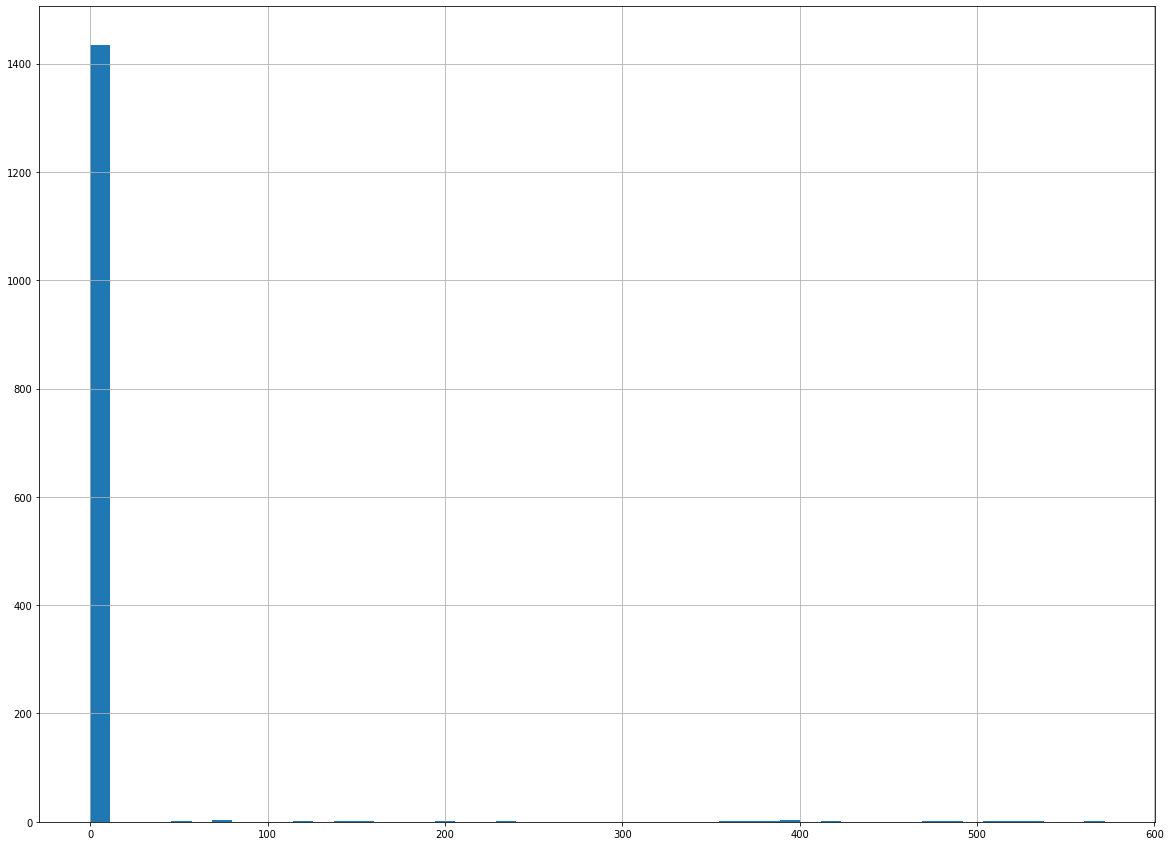

GrLivArea


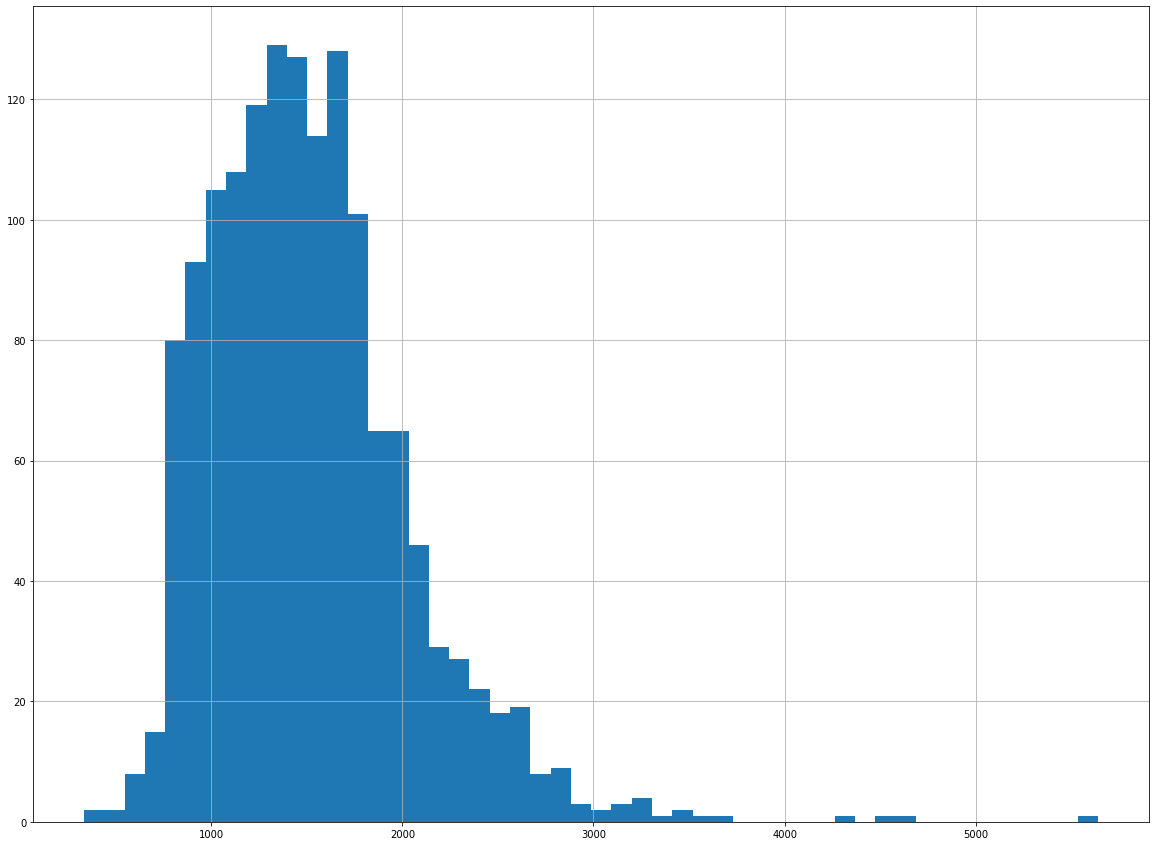

BsmtFullBath


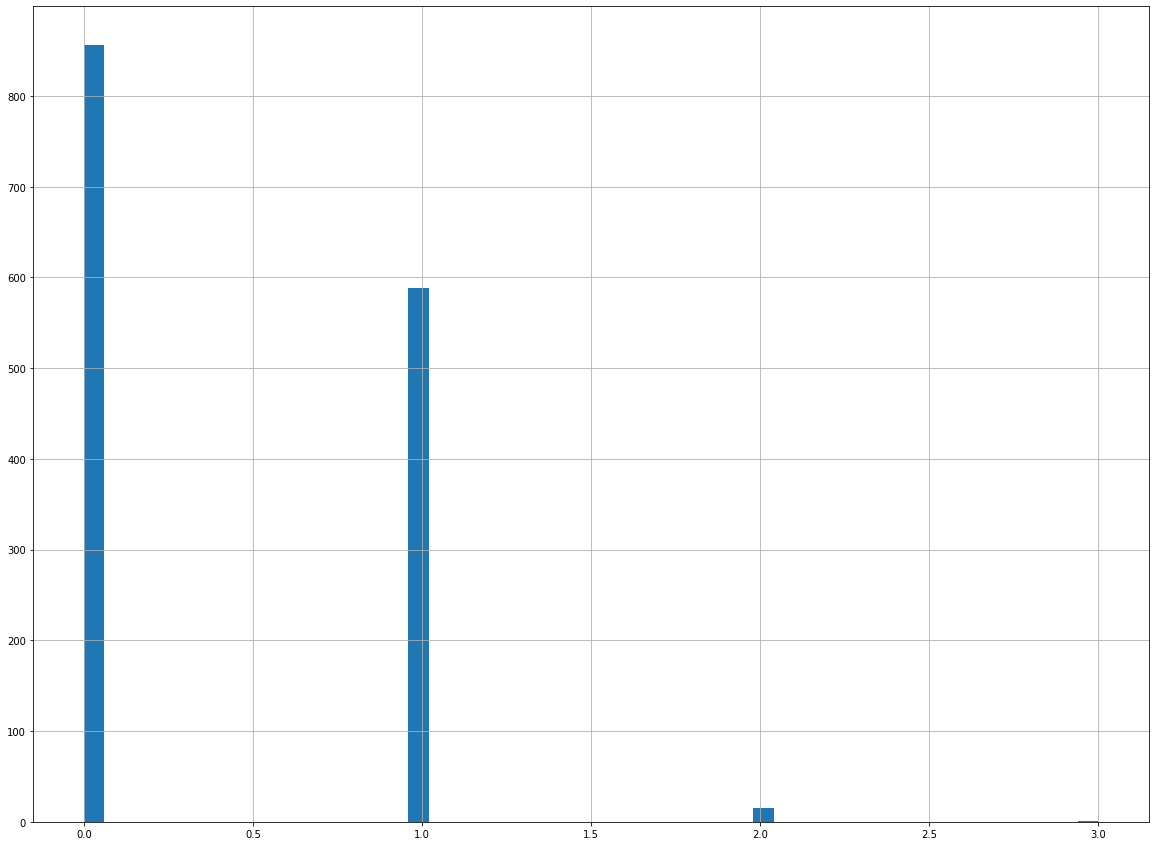

FullBath


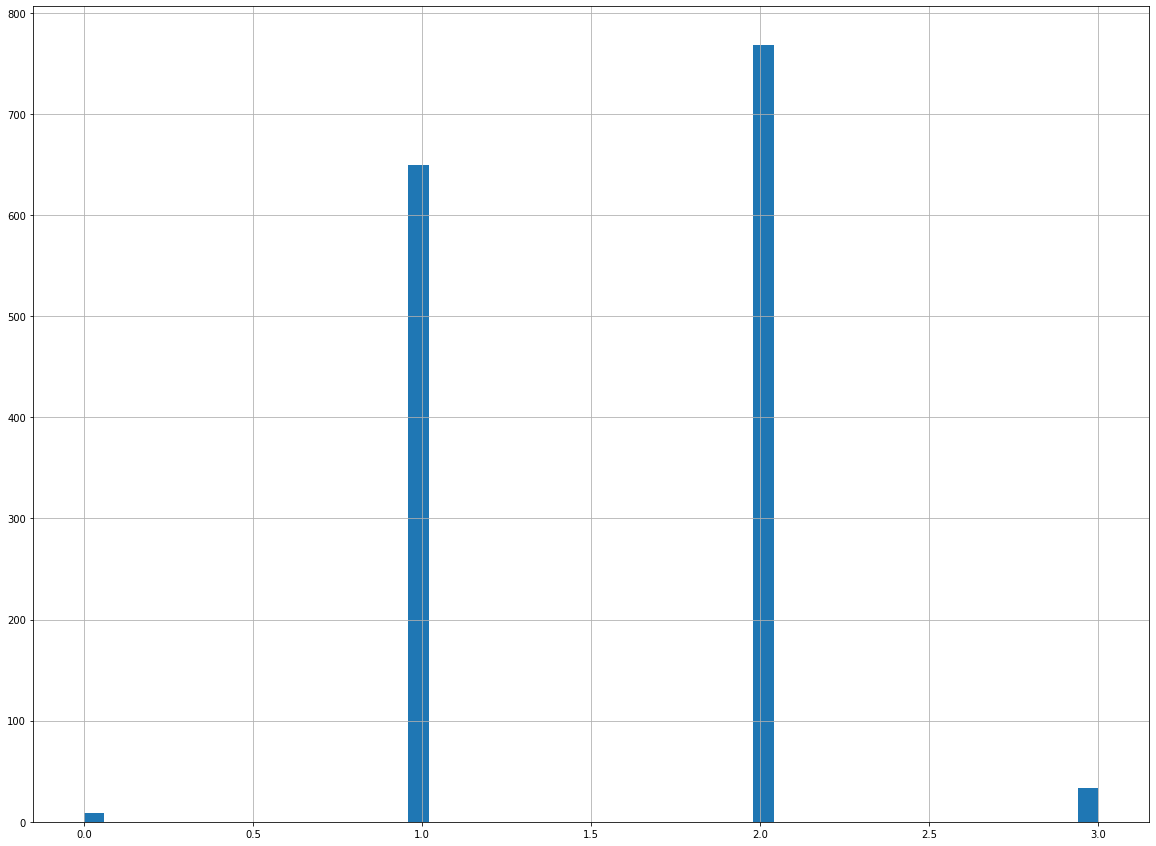

HalfBath


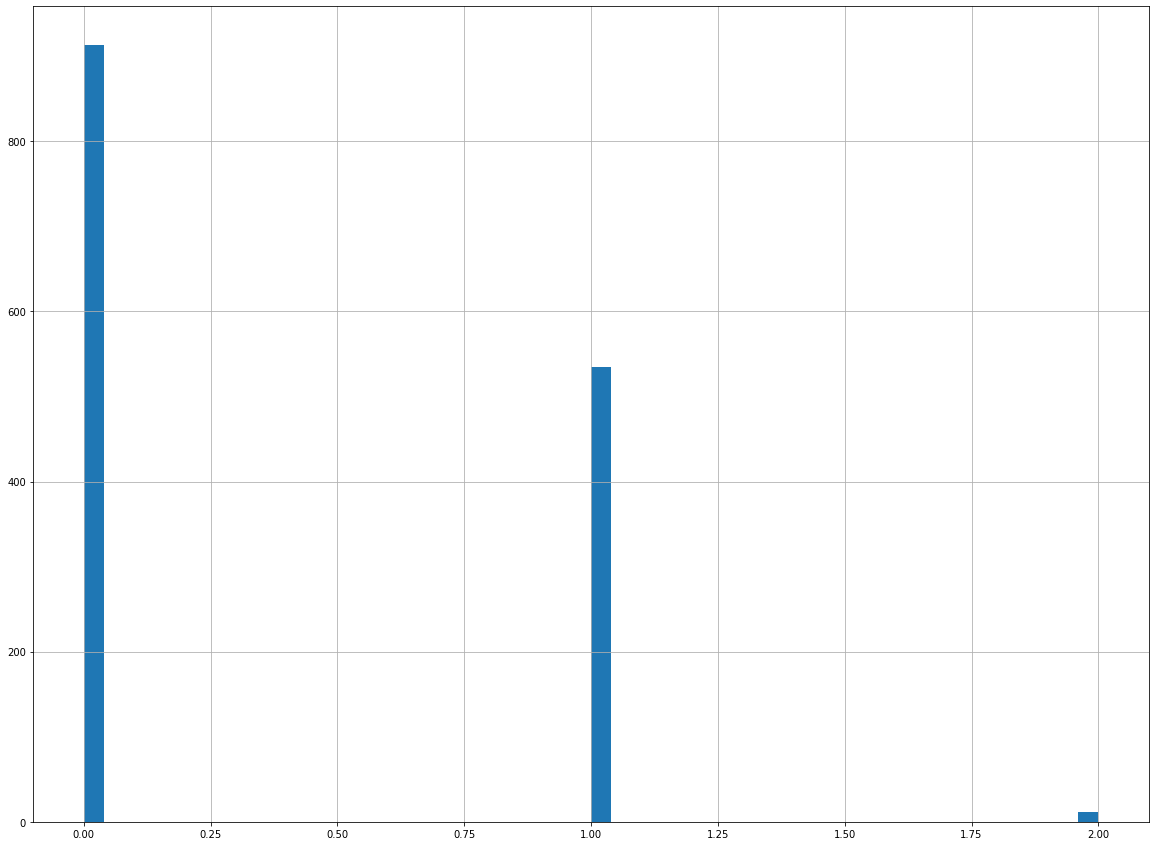

BedroomAbvGr


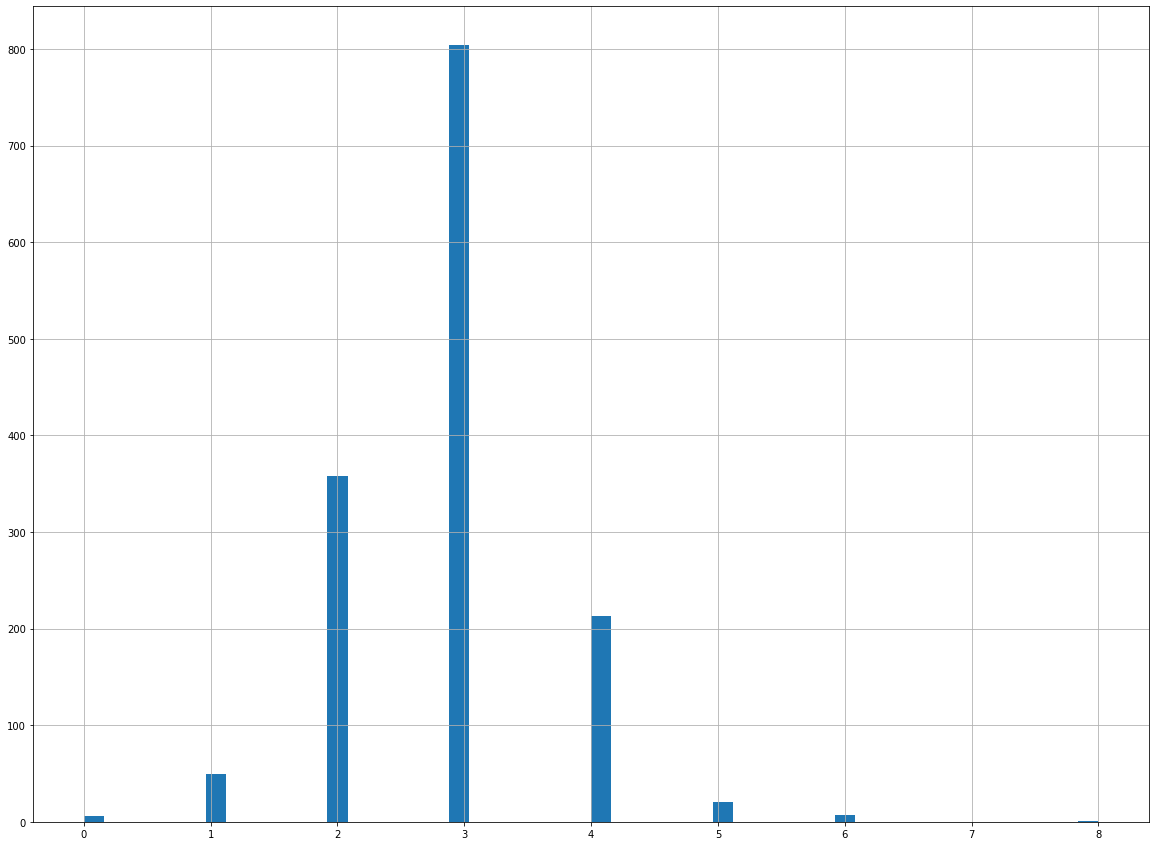

KitchenAbvGr


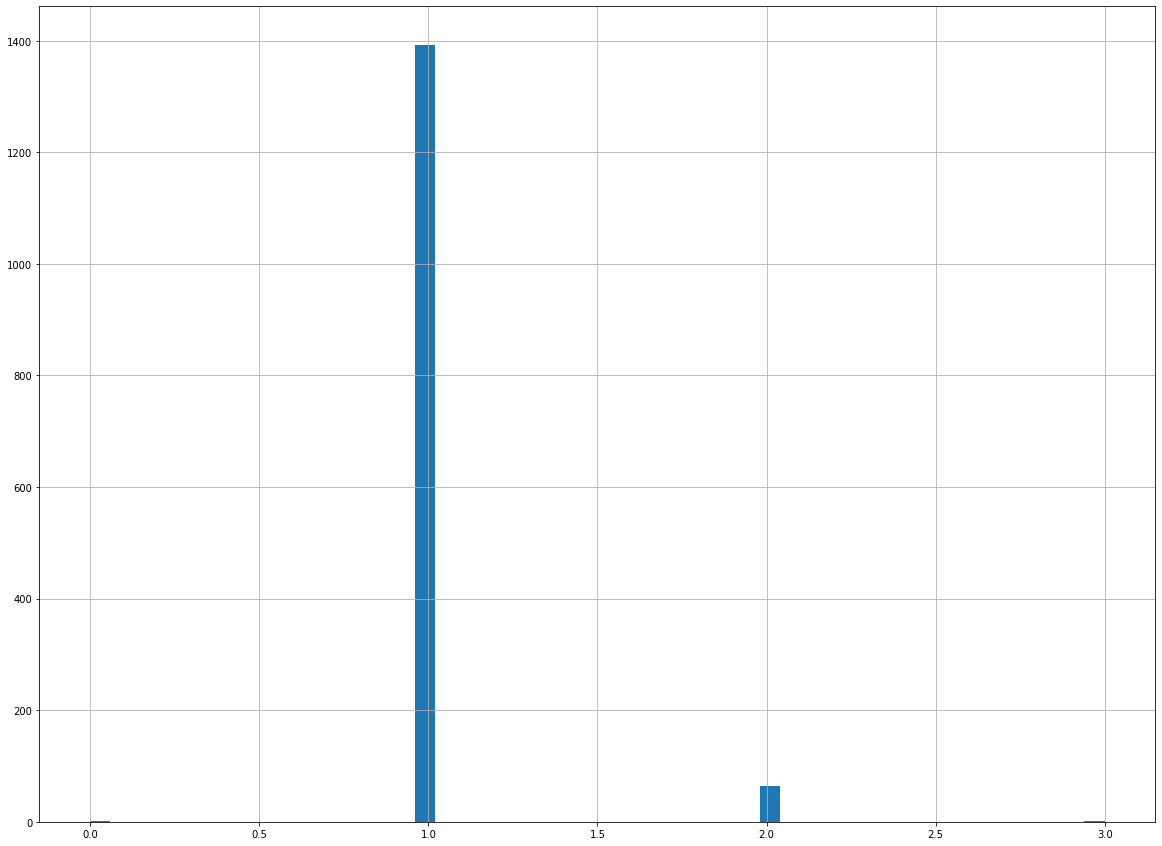

TotRmsAbvGrd


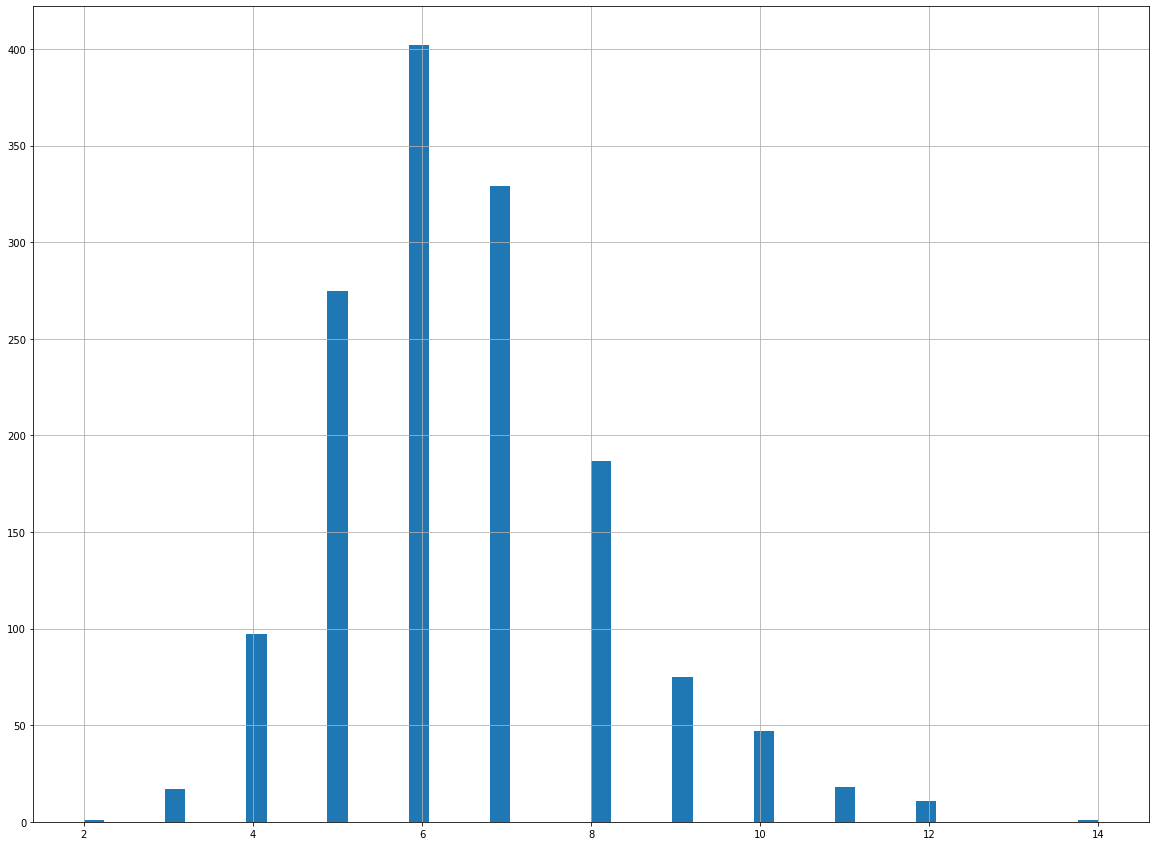

GarageArea


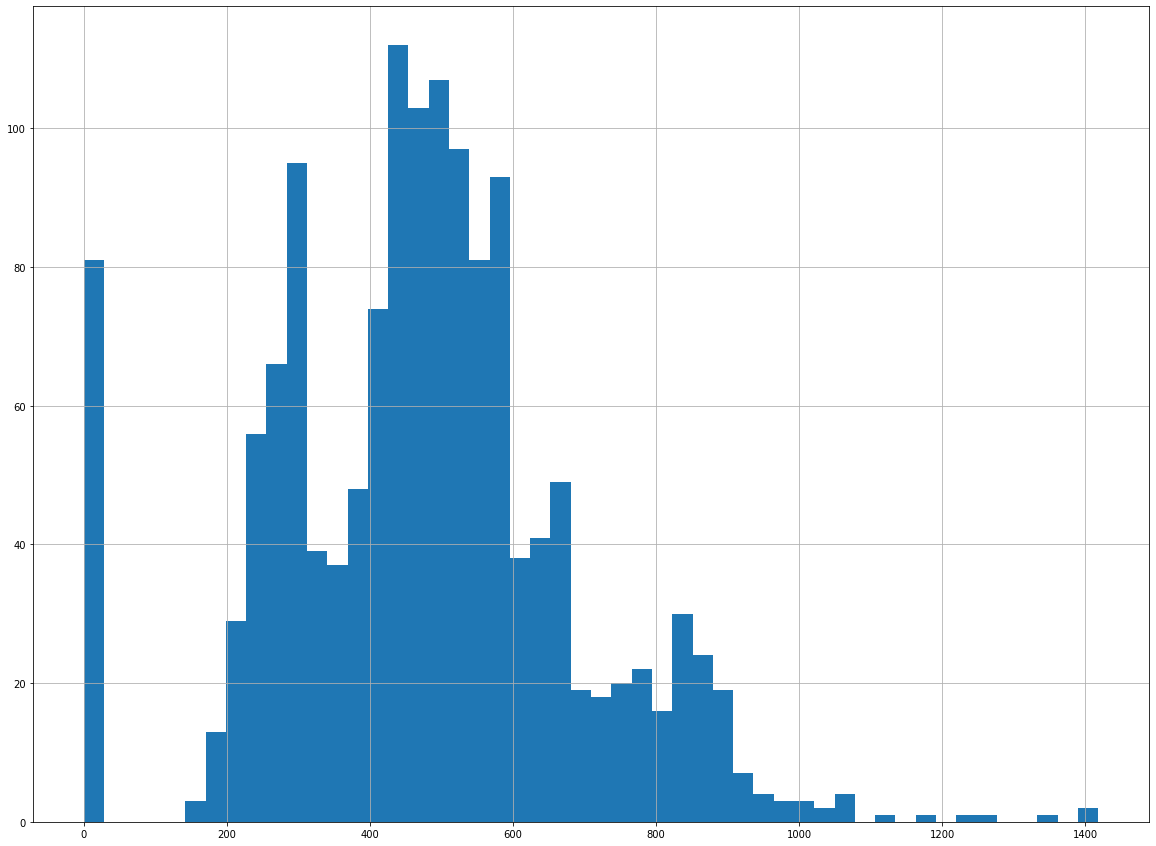

MiscVal


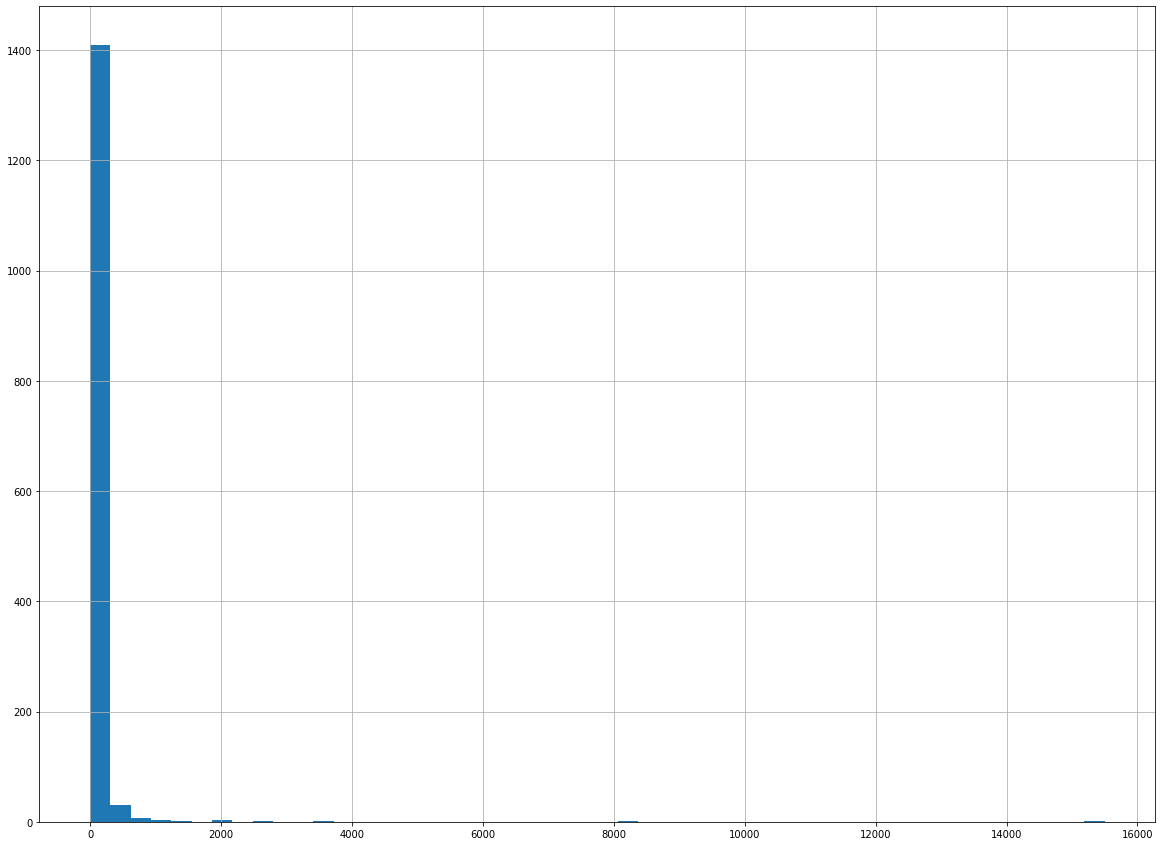

MoSold


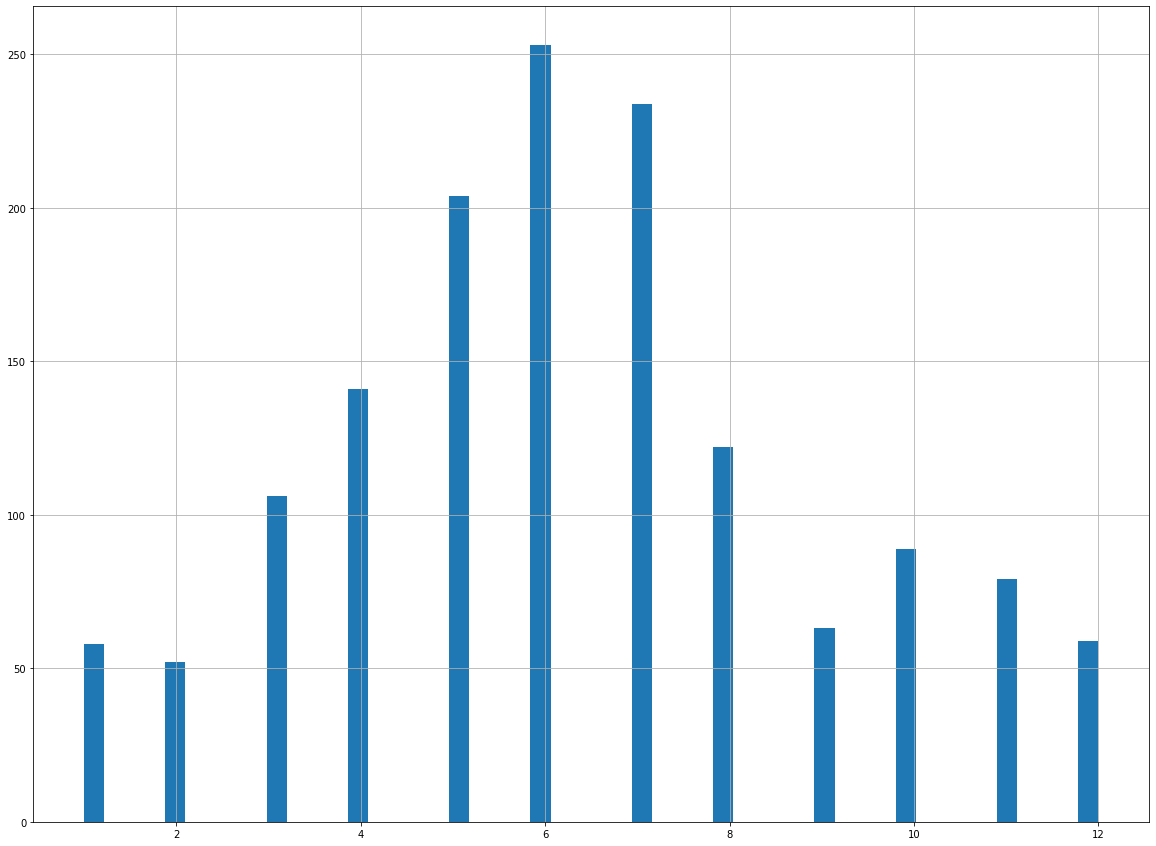

YrSold


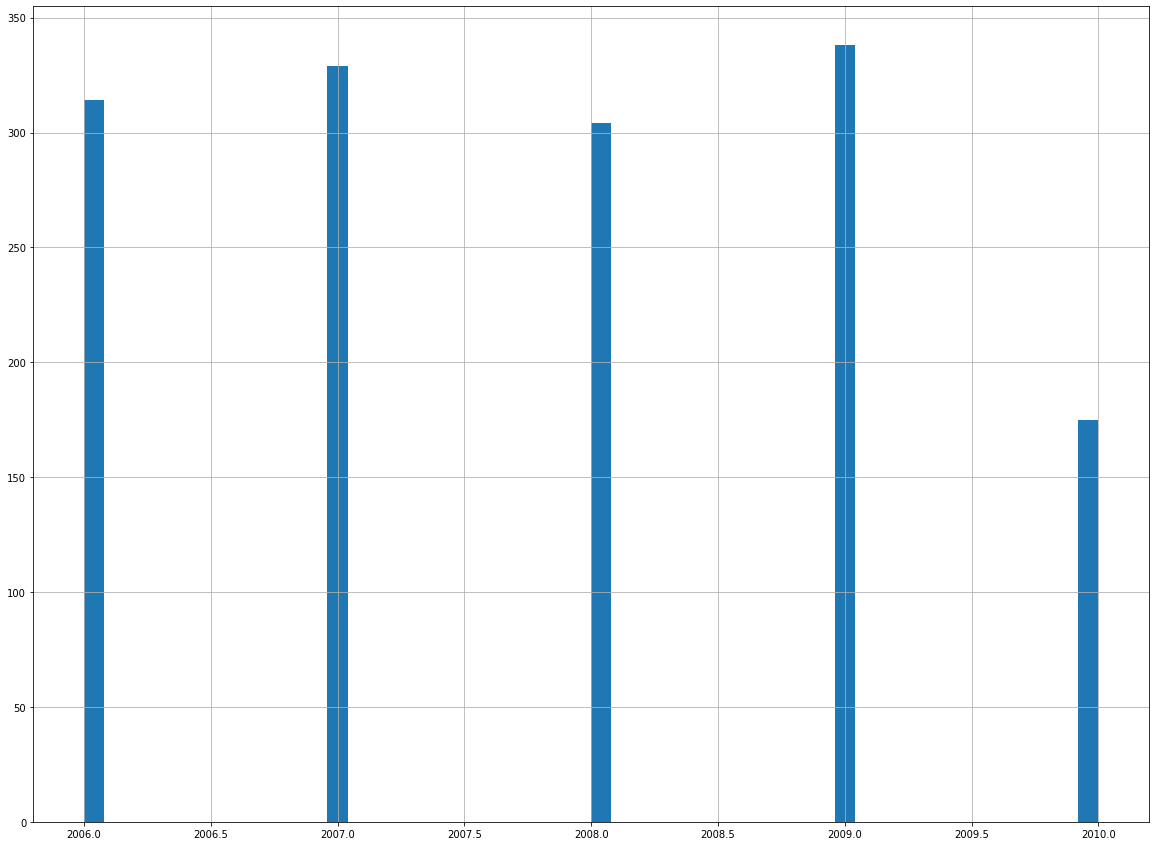

SalePrice


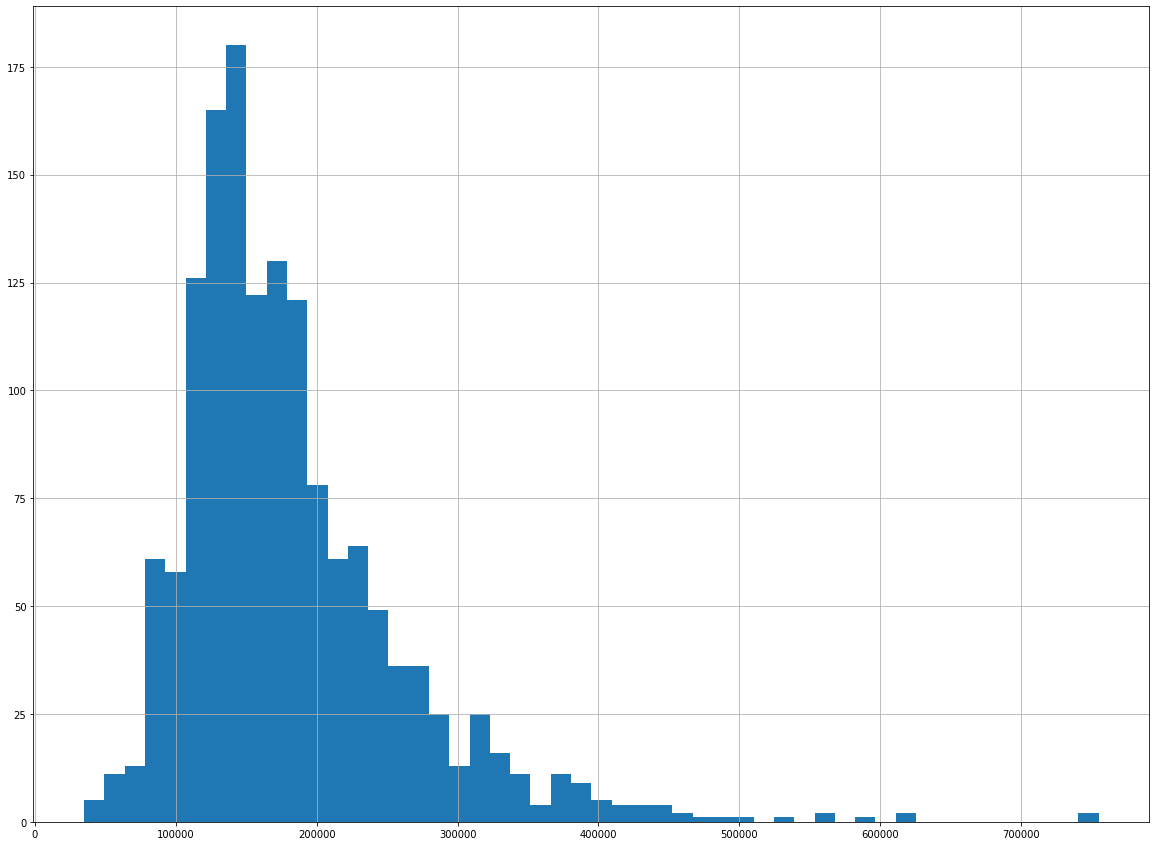

In [13]:
#поищем выбросы в оставшихся данных
for i in train.columns:
    if train[i].dtype == float or train[i].dtype == int:
        print(i)
        train[i].hist(bins = 50, figsize = (20, 15))
        plt.show()

In [14]:
train.drop(train[train['MiscVal'] > 2500].index.tolist(), inplace = True) 
train.drop(train[train['SalePrice'] > 600000].index.tolist(), inplace = True) 
train.drop(train[train['TotalBsmtSF'] > 4000].index.tolist(), inplace = True) 
train.drop(train[train['GrLivArea'] > 4000].index.tolist(), inplace = True) 
train.drop(train[train['LotArea'] > 100000].index.tolist(), inplace = True) 
train.drop(train[train['LotFrontage'] > 300].index.tolist(), inplace = True) 
train.drop(train[train['BsmtFinSF1'] > 3000].index.tolist(), inplace = True) 

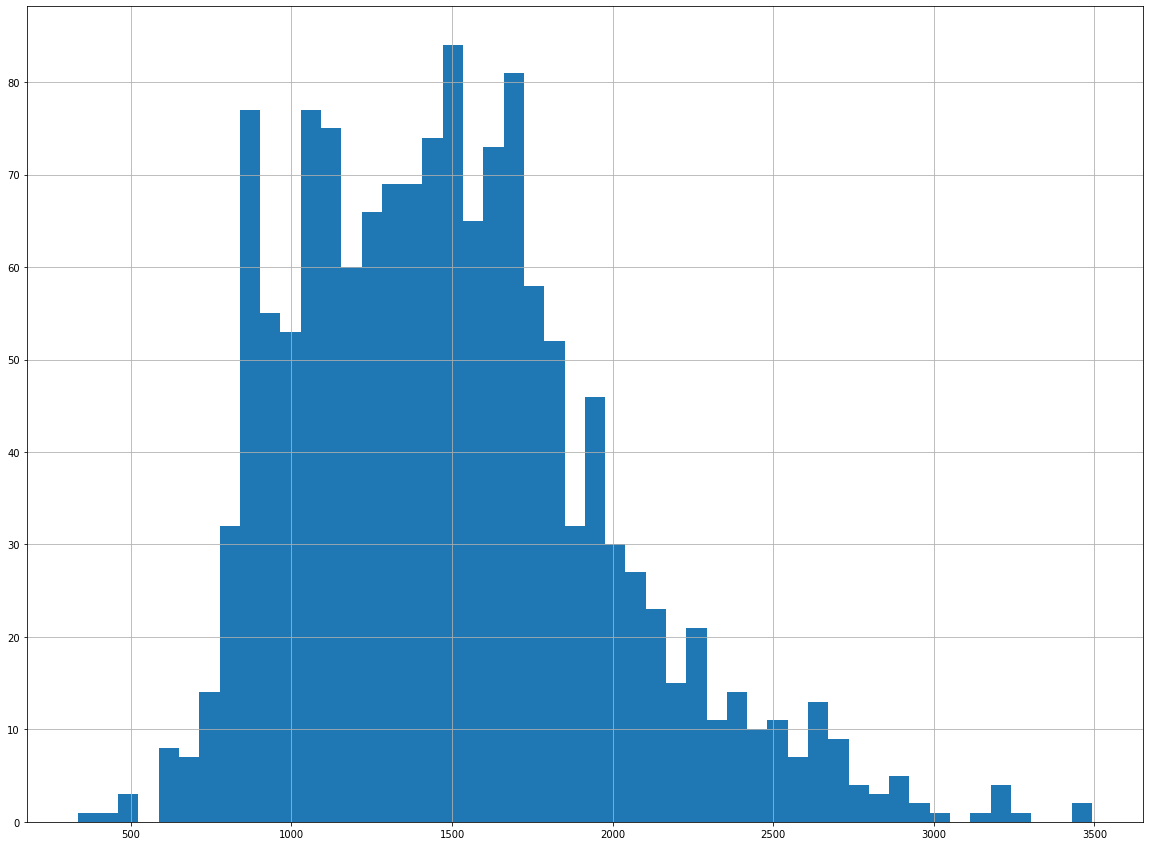

In [15]:
# площадь первого и второго этажа хорошие фич по отдельности, но не у всех домов есть второй этаж, 
# лучше оказалась вместо них использовать общую площадь и отдельно бинарную фичу для индикации наличия второго этажа.
train['overall_sf'] = train['1stFlrSF'] + train['2ndFlrSF']
train['overall_sf'].hist(bins = 50, figsize = (20, 15))
plt.show()

In [16]:
train.drop(train[train['overall_sf'] > 3300].index.tolist(), inplace = True) #убираем выбросы
corr_matrix = train.corr()
corr_matrix['SalePrice'].sort_values(ascending = False)

SalePrice       1.000000
OverallQual     0.804918
overall_sf      0.727164
GrLivArea       0.717418
TotalBsmtSF     0.644206
GarageArea      0.638149
1stFlrSF        0.616627
FullBath        0.557095
TotRmsAbvGrd    0.532670
BsmtFinSF1      0.381994
LotArea         0.357645
LotFrontage     0.338192
2ndFlrSF        0.294408
HalfBath        0.284762
BsmtFullBath    0.229646
BedroomAbvGr    0.160687
MoSold          0.063289
MiscVal        -0.023401
LowQualFinSF   -0.024401
YrSold         -0.024582
MSSubClass     -0.083591
KitchenAbvGr   -0.137257
Name: SalePrice, dtype: float64

In [17]:
train['one_or_two_floors'] = 0
train.loc[train['2ndFlrSF'] > 0, ['one_or_two_floors']] = 1

test['overall_sf'] = test['1stFlrSF'] + test['2ndFlrSF']
test['one_or_two_floors'] = 0
test.loc[test['2ndFlrSF'] > 0, ['one_or_two_floors']] = 1

train.drop(['1stFlrSF', '2ndFlrSF'], axis = 1, inplace = True)
test.drop(['1stFlrSF', '2ndFlrSF'], axis = 1, inplace = True)

Заметка: это всё можно обернуть в CustomTransformer, но так как Kaggle это one-and-done история, мне это показалось лишним

**2: Preprocessing**

In [18]:
train_labels = train['SalePrice'].copy()
train_set = train.drop('SalePrice', axis = 1)

In [19]:
num_features = []
cat_features = []
for i in train_set.columns:
    if train_set[i].dtype == object:
        cat_features.append(i)
    else:
        num_features.append(i)

In [20]:
prep_pipeline = ColumnTransformer([
    ('num_f', StandardScaler(), num_features),
    ('cat_f', OneHotEncoder(), cat_features),
])

train_preped = prep_pipeline.fit_transform(train_set)
test_preped = prep_pipeline.transform(test)

**3: Обучаем модели**

In [21]:
#попробуем несколько моделей, посмотрим что лучше
sgd_reg = SGDRegressor()

scores = cross_val_score(sgd_reg, train_preped, train_labels, 
               scoring = 'neg_mean_squared_error', cv = 5)

sgd_reg_scores = np.sqrt(-scores)
print(sgd_reg_scores)
print(sgd_reg_scores.mean())
print(sgd_reg_scores.std())

[23497.64787087 22480.60389709 26413.99007983 22066.83730902
 24856.43554246]
23863.102939851775
1597.821397248831


In [22]:
sv_reg = SVR()

scores = cross_val_score(sv_reg, train_preped, train_labels, 
               scoring = 'neg_mean_squared_error', cv = 5)

sv_reg_scores = np.sqrt(-scores)
print(sv_reg_scores)
print(sv_reg_scores.mean())
print(sv_reg_scores.std())


[77141.36615239 82822.36799778 82459.22557752 67051.70793932
 71518.24789824]
76198.58311304988
6156.782817239555


In [23]:
sv_reg_poly_kernel = SVR(kernel = 'poly', degree = 2, coef0 = 1)

scores = cross_val_score(sv_reg_poly_kernel, train_preped, train_labels, 
               scoring = 'neg_mean_squared_error', cv = 5)

sv_reg_poly_scores = np.sqrt(-scores)
print(sv_reg_poly_scores)
print(sv_reg_poly_scores.mean())
print(sv_reg_poly_scores.std())

[76899.77798396 82564.83458176 82210.76643293 66818.56297094
 71305.15394045]
75959.81918200772
6145.121091426448


In [24]:
gb_reg = GradientBoostingRegressor()

scores = cross_val_score(gb_reg, train_preped, train_labels, 
               scoring = 'neg_mean_squared_error', cv = 5)

gb_reg_scores = np.sqrt(-scores)
print(gb_reg_scores)
print(gb_reg_scores.mean())
print(gb_reg_scores.std())

[23416.07745883 23135.14654793 25418.78654374 20369.03013811
 24631.7060908 ]
23394.149355880603
1723.3462793396304


In [25]:
# как неожиданно, что Gradien Boosting и Gradient Descent Regressor, оказались лучшими
# посмотрим как различные параметны будут на них влиять 
sgd_reg = SGDRegressor()
gb_reg = GradientBoostingRegressor()

param_grid_sgd  = {
    'penalty' : ['elasticnet'], 
    'l1_ratio' : [0, 0.3, 0.5, 0.7, 1]
}

param_grid_gb = {
    'learning_rate' : [0.8, 0.1, 0.3,],
    'n_estimators' : [100, 125, 150],
    'max_depth' : [3, 4, 5]
}

grid_search_sgd = GridSearchCV(sgd_reg, param_grid_sgd, cv = 5,
                              scoring = 'neg_mean_squared_error',
                              return_train_score = True)

grid_search_sgd.fit(train_preped, train_labels)

grid_search_gb = GridSearchCV(gb_reg, param_grid_gb, cv = 5,
                             scoring = 'neg_mean_squared_error',
                             return_train_score = True)

grid_search_gb.fit(train_preped, train_labels)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.8, 0.1, 0.3],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 125, 150]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [26]:
grid_search_gb.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}

In [27]:
grid_search_sgd.best_params_

{'l1_ratio': 1, 'penalty': 'elasticnet'}

In [28]:
cvres_gb = grid_search_gb.cv_results_
for mean_score, params in zip(cvres_gb["mean_test_score"], cvres_gb["params"]):
    print(np.sqrt(-mean_score), params)

30507.122221574664 {'learning_rate': 0.8, 'max_depth': 3, 'n_estimators': 100}
30539.9159590028 {'learning_rate': 0.8, 'max_depth': 3, 'n_estimators': 125}
30932.7842448973 {'learning_rate': 0.8, 'max_depth': 3, 'n_estimators': 150}
33283.923174089075 {'learning_rate': 0.8, 'max_depth': 4, 'n_estimators': 100}
33567.14681704028 {'learning_rate': 0.8, 'max_depth': 4, 'n_estimators': 125}
33185.58388800619 {'learning_rate': 0.8, 'max_depth': 4, 'n_estimators': 150}
34662.05552404758 {'learning_rate': 0.8, 'max_depth': 5, 'n_estimators': 100}
34480.250559168846 {'learning_rate': 0.8, 'max_depth': 5, 'n_estimators': 125}
34119.0658559562 {'learning_rate': 0.8, 'max_depth': 5, 'n_estimators': 150}
23427.406557748836 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
23117.645001003748 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 125}
23100.963019894094 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}
23911.529446416058 {'learning_rate': 0.1, 'max_depth': 4, 'n_

In [29]:
cvres_sgd = grid_search_sgd.cv_results_
for mean_score, params in zip(cvres_sgd["mean_test_score"], cvres_sgd["params"]):
    print(np.sqrt(-mean_score), params)

24020.666374904682 {'l1_ratio': 0, 'penalty': 'elasticnet'}
24049.65589939876 {'l1_ratio': 0.3, 'penalty': 'elasticnet'}
24062.575560649635 {'l1_ratio': 0.5, 'penalty': 'elasticnet'}
24192.540862528094 {'l1_ratio': 0.7, 'penalty': 'elasticnet'}
23977.90088108981 {'l1_ratio': 1, 'penalty': 'elasticnet'}


Заметка: ошибка около 24000, что в половину меньше std (79000), неплохо

In [30]:
#и финальная модель
final_gb_reg = GradientBoostingRegressor(n_estimators = 200)
final_gb_reg.fit(train_preped, train_labels)

GradientBoostingRegressor(n_estimators=200)

In [31]:
test_predictions = final_gb_reg.predict(test_preped)

In [32]:
#результаты в read.me
output = pd.DataFrame({'Id': test_ids, 'SalePrice': test_predictions})
output.to_csv('submission.csv', index=False)
print(output.head())

     Id      SalePrice
0  1461  136586.643162
1  1462  161586.964714
2  1463  172719.575607
3  1464  186404.302066
4  1465  194370.523965
